# CMB+ACT: Likelihoods and Sampling


This notebook is a combination of the work covered in the CMB Analysis Workbook Part 08, and the ACT DR4/5 Section 11 Likelihood notebook. We'll start from the basics of getting theory spectra from a set of cosmological parameters, through an example with the ACT likelihood, and MCMC sampling. 


Notebook Info | Value
---|:--
Dependencies | `numpy`, `scipy`, `healpy`, `matplotlib`, `pixell`, `pyactlike`, `camb`, `pandas`, `getdist`
Data products | ACTPol_lcdm.paramnames.csv
| ACTPol_lcdm.paramnames
| ACTPol_lcdm_1.txt
Memory usage | Low
Contributors | Zack Li, Jo Dunkley, Maya Mallaby-Kay, Zach Atkins, Erminia Calabrese, Renee Hlozek


# Part 1: Preliminaries

We will start by pulling CAMB python so that we can get it running. Get pycamb from https://pypi.python.org/pypi/camb/0.1.1.

In [2]:
# Import CAMB
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
import pyactlike
import camb
from camb import model, initialpower

# Replace these paths with the paths to your data
path_to_cmb_notebook_data = '/Users/reneehlozek/Code/CMBAnalysis_SummerSchool/'
path_to_act_notebook_data = '/Users/reneehlozek/Code/DR4_Notebooks/Data/'

In [3]:
# We will start by pulling initialising the CAMB params structure that we will use later. 
#This is similar to how you would change the params.ini file 

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
# The base cosmology model is set with these params, the others are all set to their default values
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
# The initial power spectrum is set here, separately from the rest of cosmology
pars.InitPower.set_params(ns=0.965, r=0)

# Set how far in multipole we want the power spectra, and turn on defaults for the params.
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calculate results for these parameters 
# this is like "running" camb from the command line, and is the same as how it is done in cosmomc
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)

In [3]:
# Let's see what the power spectra are:
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


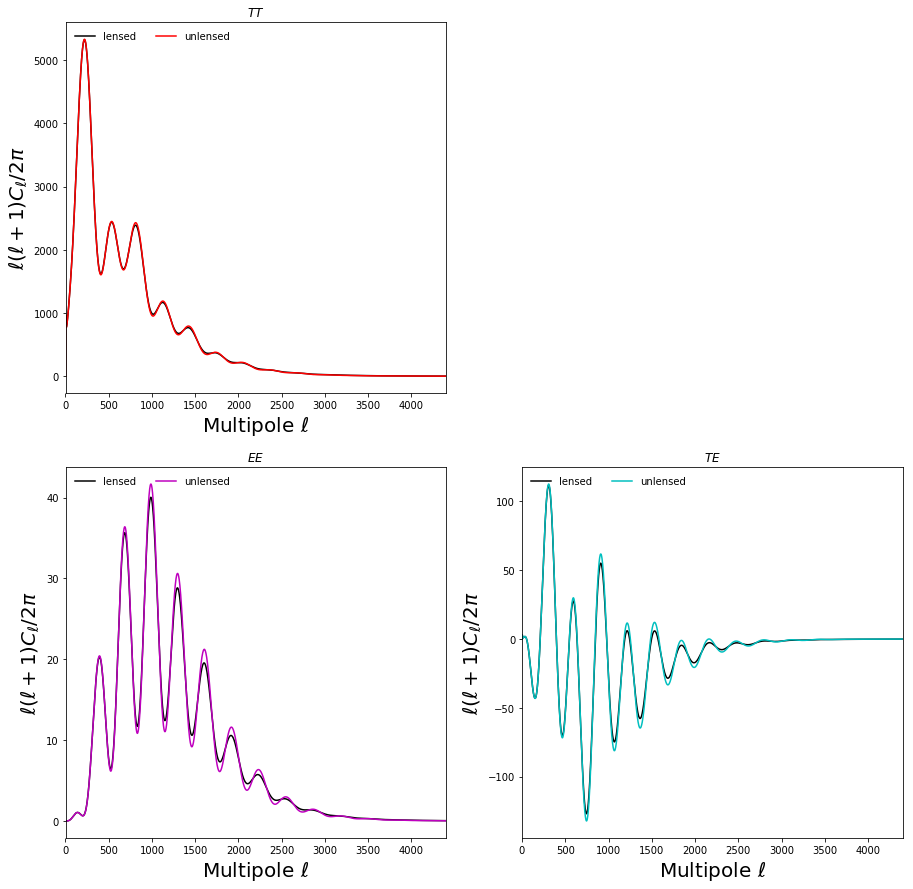

In [4]:
#Now we want to plot the total lensed and unlensed CMB power spectra
totCL=powers['total']
CMBOutscale = 7.43e12
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (15,15 ))
ax[0,0].plot(ls,CMBOutscale*totCL[:,0], color='k', label='lensed')
ax[0,0].plot(ls,CMBOutscale*unlensedCL[:,0], color='r', label='unlensed')
ax[0,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[0,0].set_xlabel(r'Multipole $\ell$', fontsize=20)
ax[0,0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
ax[0,0].set_title(r'$TT$')
ax[0,1].axis('off')
ax[1,0].plot(ls,CMBOutscale*totCL[:,1], color='k', label='lensed')
ax[1,0].plot(ls,CMBOutscale*unlensedCL[:,1], color='m', label='unlensed')
ax[1,0].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2,frameon=False)
ax[1,0].set_title(r'$EE$')
ax[1,0].set_xlabel(r'Multipole $\ell$', fontsize=20)
ax[1,0].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
ax[1,1].plot(ls,CMBOutscale*totCL[:,3], color='k', label='lensed')
ax[1,1].plot(ls,CMBOutscale*unlensedCL[:,3], color='c', label='unlensed')
ax[1,1].legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, frameon=False)
ax[1,1].set_title(r'$TE$');
ax[1,1].set_xlabel(r'Multipole $\ell$', fontsize=20)
ax[1,1].set_ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)

for ax in ax.reshape(-1): ax.set_xlim([2,4400])

### Now that we have run camb once and know how to do it, we can also compute the Cls over a range of parameters.

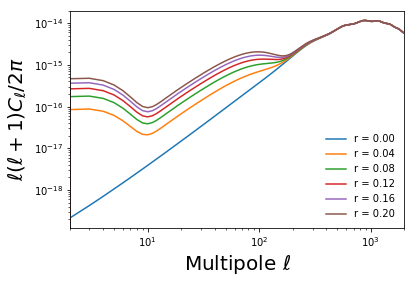

In [5]:
#You can calculate spectra for different primordial power spectra without recalculating everything
#for example, let's plot the BB spectra as a function of r
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerLaw()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params)
    cl = results.get_total_cls(lmax)
    plt.loglog(np.arange(lmax+1),cl[:,2], label='r = %.2f'%r)
plt.xlim([2,lmax])
plt.xlabel(r'Multipole $\ell$', fontsize=20)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
plt.legend( loc='lower right', frameon=False);

## Part Two: Simplified fake likelihood for some TT data. 
We'll start with a very simple diagonal likelihood that is easy to understand. We will replace this with the real ACT likelihood later.

In [6]:
## Fake likelihood based on realistic high-ell noise for CMB S4 data 

def s4_tt_likelihood(modell,loaddata=True,path=path_to_cmb_notebook_data):
    if loaddata: 
        # if it is the first time, load the data
        data = np.loadtxt(path+'./binned_errors.dat', unpack=True)
    modeltt = np.zeros(len(data[0]))
    inds = (data[0]-0.5)
    inds = inds.astype(int)
    for i,ind in enumerate(inds):
        modeltt[i] = modell[ind]  
    loglike = (data[1]-modeltt)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike
    

The first thing we notice is that we shouldn't just be taking the model spectrum at that bin, but we should be <font color='orange'> binning </font> the theory.

### Binning the data
We'll start by using a top hat binning function from some lower bound to an upper bound, with evenly spaced bins.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[500, 2500, 0, 2000]

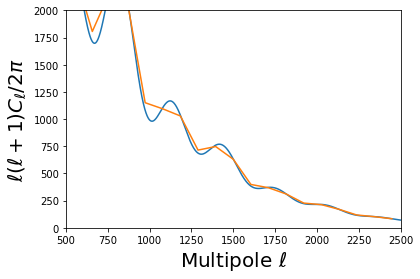

In [7]:
# Read in the ell values for the data
low_bin = 500
high_bin = 2500
nbin = 20

# First we need to make sure that the theory power spectra are in Cls and not Dl = l^2Cl/2pi
dl_tt = CMBOutscale*totCL[:,0]
cl_tt = 2*np.pi*CMBOutscale*totCL[:,0]/ls**2

# now making a vector of binned ell and a placeholder vector of cls
ellbin = np.linspace(low_bin,high_bin,nbin)
ellmids = ellbin[0:-1]+ (ellbin[1:]-ellbin[0:-1])/2
clttbin = 0*ellmids

for c,ell in enumerate(ellbin[:-1]):
    inds = np.where((ls > ell)& (ls <= ellbin[c+1]))[0]
    clttbin[c] = np.mean(cl_tt[inds])

# Now transform the Cl values back to Dl
dlttbin = ellmids**2*clttbin/(2*np.pi)
plt.plot(ls,dl_tt, label='unbinned')
plt.plot(ellmids,dlttbin, label='binned')
plt.xlabel(r'Multipole $\ell$', fontsize=20)
plt.ylabel(r'$\ell(\ell+1)C_\ell/2\pi$', fontsize=20)
plt.axis([500,2500,0,2000])

<font color='red'> EXERCISE: </font> Play around with the above binning by changing the range and number of bins. Can you think about how you would change the binning window function from this simple flat (top-hat) function?

## Implementing binning inside the likelihood
Often this binning happens inside the likelihood itself. So let's modify the simple likelihood above to bin the theory


In [8]:
## Fake likelihood based on realistic high-ell noise for CMB S4 data 

def s4_tt_likelihood_binned(modell,loaddata=True,path=path_to_cmb_notebook_data):
    if loaddata: 
        # if it is the first time, load the data
        data = np.loadtxt(path+'./binned_errors.dat', unpack=True)
    
    modeltt = np.zeros(len(data[0]))
    model_ell = np.arange(len(modell))
    
    # Making our binning vector
    midpt_ells = data[0]
    delta_ells = midpt_ells[2]-midpt_ells[1]
    
    ell_bins = midpt_ells - delta_ells/2.
    ell_bins[0] = 10 # In this case we don't want to sum ells below 10
    
    ell_bins=np.append(ell_bins, ell_bins[-1]+ delta_ells/2. )

    # converting to Cl before averaging
    cltt = 2*np.pi*modell/(model_ell**2)
    
    for i,ell in enumerate(ell_bins[0:-1]):
        inds = np.where((model_ell > ell)& 
                        (model_ell <= ell_bins[i+1]))[0]
        
        modeltt[i] = np.mean(cltt[inds])
    # converting back to Dl to do the chi^2 computation
    modeltt = modeltt*data[0]**2/(2*np.pi)
    loglike = (data[1]-modeltt)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike
   
    

In [9]:
# Let's compare
loglike = s4_tt_likelihood(dl_tt)
loglike_binned = s4_tt_likelihood_binned(dl_tt)
print(loglike, loglike_binned)

-5083.454467454073 -6128.3813915177625


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Note the difference between the two results run on the same data vector

## Part Three: Real data likelihoods

Let's now look at the real ACT likelihood. Here are we reading in the ACT-only best-fit spectrum as theory, and we also need to define the `yp2` needed in the ACTlikelihood to 1.001, and for comparison's sake, we load a new spectrum -- that which maximizes the likelihood at the new value of `
yp2`:


In [10]:
like = pyactlike.ACTPowerSpectrumData()
# Read in the act only spectra
filename = like.data_dir + "/bf_ACTPol_lcdm.minimum.theory_cl"

tt_lmax = 6000
ell, dell_tt, dell_te, dell_ee = np.genfromtxt(
    filename,
    delimiter=None,
    unpack=True,
    max_rows=tt_lmax - 1,
    usecols=(0, 1, 2, 3),
)

# Set the new yp2 value
yp2_act_only = 1.001

# Now let's look at the chi2 using pyactlike
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt, dell_te, dell_ee, yp2_act_only)
print("ACT only chi2 = " + "{0:.12f}".format(chi2))
print("Expected:       279.005057627002")

ACT only chi2 = 279.005057627002
Expected:       279.005057627002


Now let's take a moment to compare our theoretical predictions to the data. In order to do se we want to identify the TT, TE and EE bins, data and errors. We will look at the 'wide' patch data. The particular spectrum (TT, EE, etc.) and coadded patch information is set by the indices applied to the `like` instance variables:

In [11]:
wmin=130 #first element of TT data vector for wide patch
wmax=130+40 #last element of TT for wide patch

# Read in the ell values for the data
TT_bval=like.bval[wmin:wmax]

# Compute the Dl values using Dl = cl*ell*(ell+1)/(2*pi) 
TT_dat=like.X_data[wmin:wmax]*(like.bval[wmin:wmax]+1)*like.bval[wmin:wmax]/(2.*np.pi)

# Read in the error which also needs to be converted to an error in Dl
TT_err=like.X_sig[wmin:wmax]*(like.bval[wmin:wmax]+1)*like.bval[wmin:wmax]/(2.*np.pi)

(0, 6000)

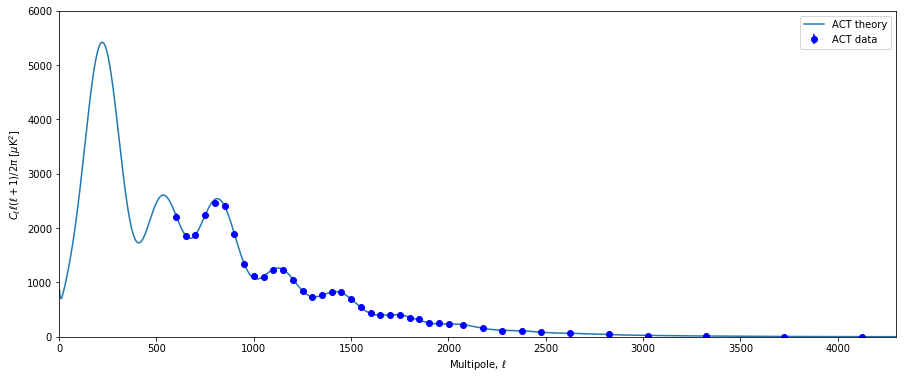

In [12]:
# Now we can plot this data along with the theory from above 
plt.figure(figsize=(15,6))

plt.plot(ell, dell_tt, "-", label="ACT theory")
plt.errorbar(TT_bval,TT_dat,yerr = TT_err, fmt='bo',label="ACT data")
plt.xlabel(r"Multipole, $\ell$")
plt.ylabel(r"$C_{\ell} \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$")
plt.legend()
plt.xlim(0,4300)
plt.ylim(0,6000)

By eye this looks pretty good, our data points seem to fit our theory extremely well.  We can test this more explicitly by looking at the residuals and printing out a simplified diagonal $\chi^2$.  It's worth noting that in order to get the full $\chi^2$ one would need to use the full likelihood (with `like.loglike`) instead of this simplified version.

Now identify the bandpower window functions to bin the theory, plot residuals, and also print simplified diagonal $\chi^2$ (again, for fully-accurate $\chi^2$, use the full likelihood!). First, we obtain a binned theory spectrum, to compare with the binned data stored inside `like`:

In [13]:
# We begin by creating an array of ell values the range from 2 to 5000
l_list = np.array(range(2, like.tt_lmax + 1))

# Our data above was binned and so in order to compare to theory we 
# will need to similarly bin the theory curve from above

# Start by reading in the Dl values annd converting to cls
cltt = np.zeros(like.lmax_win)
cltt[1 : like.tt_lmax] = (dell_tt[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)

# now we bin these cl values just as we did for the data above
bmax, lmax_win = like.bmax, like.lmax_win
cth_tt = like.win_func_w[2 * bmax : 3 * bmax, 1:lmax_win] @ cltt[1:lmax_win] 

# We convert the binned cl values back to binned Dl by multiplying through by l(l+1)/2pi
dth_tt = cth_tt[like.b0:like.b0+like.nbintt]*(like.bval[wmin:wmax]+1)*like.bval[wmin:wmax]/(2.*np.pi) 

(-100, 70)

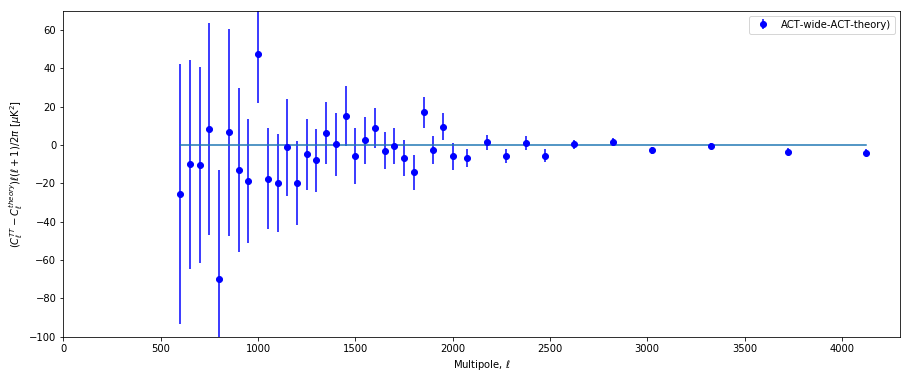

In [14]:
# Now we have binned data and binned theory and so can plot the residuals
plt.figure(figsize=(15,6))
plt.errorbar(TT_bval,TT_dat-dth_tt,yerr = TT_err, fmt='bo',label="ACT-wide-ACT-theory)")
plt.plot(TT_bval, (TT_dat-dth_tt)*0.)
plt.xlabel(r"Multipole, $\ell$")
plt.ylabel(r"$(C_{\ell}^{TT}-C_{\ell}^{theory}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$")
plt.legend()
plt.xlim(0,4300)
plt.ylim(-100,70)

Finally, from the residuals and errors we loaded earlier, we can evaluate our "diagonal" $\chi^2$:

In [15]:
# We can also find the chisq of this binned data and print it out
chi_act_TT = (TT_dat-dth_tt)**2/TT_err**2
print("ACT TT-wide diagonal chi2 = " + "{0:.2f}".format(np.sum(chi_act_TT))+ " for 40 data points")

ACT TT-wide diagonal chi2 = 39.28 for 40 data points


### Repeating for TE, EE

In [16]:
wmin_TE, wmax_TE= 130+40, 130+40+45   #set the bounds for TE
wmin_EE, wmax_EE= 130+85, 130+85+45   #set the bounds for EE

# As before we read in the ell, Dl, and error values
# For TE
TE_bval=like.bval[wmin_TE:wmax_TE]
TE_dat=like.X_data[wmin_TE:wmax_TE]*like.bval[wmin_TE:wmax_TE]*(like.bval[wmin_TE:wmax_TE]+1)/(2.*np.pi)
TE_err=like.X_sig[wmin_TE:wmax_TE]*like.bval[wmin_TE:wmax_TE]*(like.bval[wmin_TE:wmax_TE]+1)/(2.*np.pi)

# For EE
EE_bval=like.bval[wmin_EE:wmax_EE]
EE_dat=like.X_data[wmin_EE:wmax_EE]*like.bval[wmin_EE:wmax_EE]*(like.bval[wmin_EE:wmax_EE]+1)/(2.*np.pi)
EE_err=like.X_sig[wmin_EE:wmax_EE]*like.bval[wmin_EE:wmax_EE]*(like.bval[wmin_EE:wmax_EE]+1)/(2.*np.pi)

# Start by binning the EE thoery
clee = np.zeros(like.lmax_win)
clee[1 : like.tt_lmax] = (dell_ee[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)
bmax, lmax_win = like.bmax, like.lmax_win
cth_ee = like.win_func_w[9 * bmax : 10 * bmax, 1:lmax_win] @ clee[1:lmax_win] 
dth_ee = cth_ee[:like.nbinee]*like.bval[wmin_EE:wmax_EE]*(like.bval[wmin_EE:wmax_EE]*+1)/(2.*np.pi) 

# Next let's bin the TE theory
clte = np.zeros(like.lmax_win)
clte[1 : like.tt_lmax] = (dell_te[: like.tt_lmax - 1] / l_list / (l_list + 1.0) * 2.0 * np.pi)
bmax, lmax_win = like.bmax, like.lmax_win
cth_te = like.win_func_w[6 * bmax : 7 * bmax, 1:lmax_win] @ clte[1:lmax_win] 
dth_te = cth_te[:like.nbinte]*like.bval[wmin_TE:wmax_TE]*(like.bval[wmin_TE:wmax_TE]+1)/(2.*np.pi) 

ACT TE-wide diagonal chi2 = 40.77 for 45 data points
ACT EE-wide diagonal chi2 = 60.04 for 45 data points


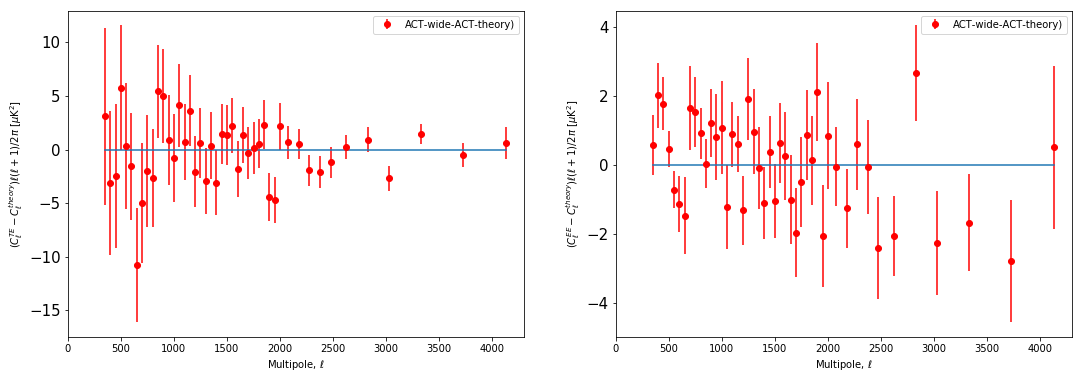

In [17]:
# Plot the residuals
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.errorbar(TE_bval,TE_dat-dth_te,yerr = TE_err, fmt='ro',label="ACT-wide-ACT-theory)")
plt.plot(TE_bval, (TE_dat-dth_te)*0.)
plt.yticks(fontsize=15)
plt.xlim(0,4300)
plt.xlabel(r"Multipole, $\ell$")
plt.ylabel(r"$(C_{\ell}^{TE}-C_{\ell}^{theory}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$")
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(EE_bval,EE_dat-dth_ee,yerr = EE_err, fmt='ro',label="ACT-wide-ACT-theory)")
plt.plot(EE_bval, (EE_dat-dth_ee)*0.)
plt.yticks(fontsize=15)
plt.xlim(0,4300)
plt.xlabel(r"Multipole, $\ell$")
plt.ylabel(r"$(C_{\ell}^{EE}-C_{\ell}^{theory}) \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$")
plt.legend()

# Print out the chi^2 values
chi_act_TE = (TE_dat-dth_te)**2/TE_err**2
print("ACT TE-wide diagonal chi2 = " + "{0:.2f}".format(np.sum(chi_act_TE))+ " for 45 data points")

chi_act_EE = (EE_dat-dth_ee)**2/EE_err**2
print("ACT EE-wide diagonal chi2 = " + "{0:.2f}".format(np.sum(chi_act_EE))+ " for 45 data points")

### Stepping in parameter space
We are now going to explore generating different model 'universes' to fit the data

In [18]:
# first generate an arbitrary set of spectra from CAMB
cosmo_params = camb.model.CAMBparams()

# set H0 to the ACT+WMAP best-fit result, set the universe curvature to be slightly positive
# set lmax for this simulation to match the rest of the notebook 
cosmo_params.set_cosmology(H0 = 67.9, omk = 0.1)
cosmo_params.set_for_lmax(6000)

# retrieve the spectra
res = camb.get_results(cosmo_params)
spectra = res.get_cmb_power_spectra(params = cosmo_params, spectra = ('total',), CMB_unit = 'muK')['total']

We can plot what our new model looks like (visually it is hard to tell the difference to our ACT-only maximum likelihood theory), but against the data the problem is clear:

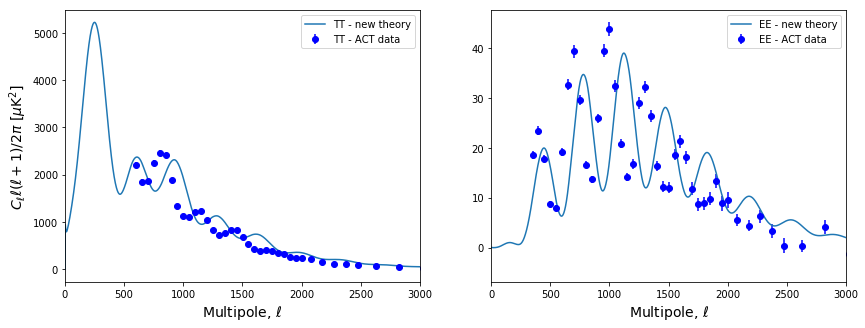

In [19]:
# we can plot the new, theory spectra as before
ell_new = np.arange(spectra.shape[0])
dell_tt_new, dell_ee_new, dell_bb_new, dell_te_new = spectra.T

plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.plot(ell_new, dell_tt_new, "-", label="TT - new theory")
plt.errorbar(TT_bval,TT_dat,yerr = TT_err, fmt='bo',label="TT - ACT data")
plt.ylabel(r"$C_{\ell} \ell (\ell+1) / 2 \pi$ $[\mu$K$^2]$", fontsize = 14)
plt.xlabel(r"Multipole, $\ell$", fontsize = 14)
plt.legend()
plt.xlim(0,3000)

plt.subplot(1,2,2)
plt.plot(ell_new, dell_ee_new, "-", label="EE - new theory")
plt.errorbar(EE_bval,EE_dat,yerr = EE_err, fmt='bo', label="EE - ACT data")
plt.xlabel(r"Multipole, $\ell$", fontsize = 14)
plt.legend()
plt.xlim(0,3000)

plt.show()

In [20]:
paramsvec=np.array([67.5,0.022, 0.122, 0, 0.06, 0.965])
pars = camb.CAMBparams()
pars.set_cosmology(H0=paramsvec[0], ombh2=paramsvec[1], omch2=paramsvec[2], mnu=0.06, omk=paramsvec[3], tau=paramsvec[4])
pars.InitPower.set_params(ns=paramsvec[5], r=0)
pars.set_for_lmax(4400, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
totCL=powers['total']
model = totCL
cltt = totCL[:,0]*CMBOutscale
loglike = s4_tt_likelihood(cltt)
print(loglike)

-5083.454467454073


Computing the $\chi^2$ for the ACT likelihood confirms this

In [21]:
# Look at the chi2 using pyactlike
like = pyactlike.ACTPowerSpectrumData()
chi2 = -2 * like.loglike(dell_tt_new, dell_te_new, dell_ee_new, yp2_act_only)
print("ACT only chi2 = " + "{0:.12f}".format(chi2))
print("Expected:       279.004901885481")

ACT only chi2 = 34355.419238471775
Expected:       279.004901885481


### Stepping in parameter space
We are now going to call CAMB with a param vector in the same way as above, and compute the log likelihood for this. We want to take a step in this 6-D parameter space specified by the step vector. 

In [22]:
paramsvec=np.array([67.5,0.022, 0.122, 0, 0.06, 0.965])
# Using this code above, we can take a gaussian step specified by the step vector below
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
nsteps = 2
loglike = np.zeros(nsteps)
for i in range(nsteps):
    if i==0:
        # First step
        step = paramsvec
    else:
        # Take a Gaussian step from the previous position
        step = step+np.random.randn(len(paramsvec))*stepvec
    # Initialise the CMAB params    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
    pars.InitPower.set_params(ns=step[5], r=0)
    pars.set_for_lmax(4400, lens_potential_accuracy=0)
    # Compute the spectra
    powers =results.get_cmb_power_spectra(pars)
    totCL=powers['total']
    model = totCL
    cltt = totCL[:,0]*CMBOutscale
    loglike[i] = s4_tt_likelihood(cltt)
print('loglike vector =', loglike)

loglike vector = [-5083.45446745 -3847.59203114]


## Part Four: Preliminaries of MCMC
We are now ready to do the MCMC. We'll define the simplest/ugliest version of the Metropolis Hastings algorithm:

In [23]:
def mcmc_mh(ratln):
    accept=False
    r1 = np.random.rand()
    # If the step is definitely better, we want to accept it.
    # If it isn't necessarily better, we want to throw a random number and step if we exceed it
    if np.exp(ratln) > r1:
        accept=True
    return accept

In [24]:
# Using this code above, we can take a gaussian step specified by the step vector below
stepvec = np.array([0.1,0.0001, 0.0001, 0, 0.005, 0.001])
stepvec = np.array([0.1,0, 0, 0, 0, 0])

steps = 10
loglike = np.zeros(steps)
stepskeep = np.zeros((steps,len(paramsvec)+1))
for i in range(steps):
    
    if i==0:
        step = paramsvec
        accept=True
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        loglike[i] = s4_tt_likelihood(cltt)
        #print loglike[i]
        stepskeep[i,0:len(paramsvec)] = step
        stepskeep[i,len(paramsvec)]= loglike[i]
    else:
        
        step = stepskeep[i-1,0:len(paramsvec)]+np.random.randn(len(paramsvec))*stepvec 
        #print step
        pars = camb.CAMBparams()
        # Put the param vector into the camb structure
        pars.set_cosmology(H0=step[0], ombh2=step[1], omch2=step[2], mnu=0.06, omk=step[3], tau=step[4])
        pars.InitPower.set_params(ns=step[5], r=0)
        pars.set_for_lmax(4400, lens_potential_accuracy=0)
        # compute the power spectrum
        powers =results.get_cmb_power_spectra(pars)
        totCL=powers['total']
        model = totCL
        cltt = totCL[:,0]*CMBOutscale
        # compute the likelihood
        loglike[i] = s4_tt_likelihood(cltt)
        rat = loglike[i]-loglike[i-1]
        accept = mcmc_mh(rat)
        
        if accept:   
            stepskeep[i,0:len(paramsvec)] = step
            stepskeep[i,len(paramsvec)] = loglike[i]
        else:
            stepskeep[i,0:len(paramsvec)] = stepskeep[i-1,0:len(paramsvec)]
            loglike[i] = loglike[i-1]
            stepskeep[i,len(paramsvec)] = loglike[i]
        
    
            
np.savetxt('chain.txt', stepskeep, delimiter=' ', fmt='%.3e')
print('we are done')

we are done


### We don't actually want to read in the data every time. 
<font color='red'>EXCERCISE: </font> Change the likelihood function to only read in the data the first time it is called.

In [25]:
## Your code here

Your notes here.

### This code is really ugly (and slow)!
<font color='red'>EXCERCISE: </font>  Write functions/modules to speed up the MCMC code above.

In [26]:
## Your code here

Your discussion here.

## Part Five: Analyzing MCMC chains

We will use MCMC chains generated using the ACT likelihood to look at parameters. The Likelihood we've introduced above can be used to solve for the best fit cosmological parameters that fit the ACT data.  This process and our results are discussed more in [Choi et al (2020)](https://phy-act1.princeton.edu/public/saiola/act_dr4_C20.pdf)  and  [Aiola et al (2020)](https://phyact1.princeton.edu/public/saiola/act_dr4_A20.pdf) but here we will show you how to use one of the MCMC chains to look at the parameters.
We begin by reading in a chain and a file with the corresponding column names.

In [27]:
# Begin by reading in a chain and names of the columns
import pandas as pd


# Read in the column names
names = pd.read_csv(path_to_act_notebook_data + "ACTPol_lcdm.paramnames.csv", names = ["parameter", "latex parameter name"])
chain = np.genfromtxt(path_to_act_notebook_data + "ACTPol_lcdm_1.txt")
names["parameter"]

0         omegabh2
1         omegach2
2            theta
3              tau
4             logA
5               ns
6               yp
7              H0*
8          omegal*
9          omegam*
10       omegamh2*
11      omeganuh2*
12       omegamh3*
13         sigma8*
14     s8omegamp5*
15    s8omegamp25*
16           s8h5*
17     rmsdeflect*
18           zrei*
19              A*
20          clamp*
21           DL40*
22          DL220*
23          DL810*
24         DL1420*
25         DL2000*
26           ns02*
27        yheused*
28          YpBBN*
29          DHBBN*
30            age*
31          zstar*
32          rstar*
33      thetastar*
34         DAstar*
35          zdrag*
36          rdrag*
37             kd*
38         thetad*
39            zeq*
40            keq*
41        thetaeq*
42      thetarseq*
43        rsDv057*
44      Hubble057*
45          DA057*
46         FAP057*
47    fsigma8z057*
48     sigma8z057*
49    chi2_ACTPol*
50     chi2_prior*
Name: parameter, dtype: object

### Making 1D parameter plots and 2D contour plots
Now that we've read in the chain we can look at the data more closely.  It's often useful to look at the 1D and 2D parameter plots, e.g. looking at just H0 or looking at H0 with Omega matter.

In this section we will demonstrate two ways that users can look at both of these plots.  The first is a straightforward example using matplotlib to make 1D and 2D plots for this chain.  The other option is to use [GetDist](https://getdist.readthedocs.io/en/latest/), a public software developed by Antony Lewis ([Lewis 2019](https://arxiv.org/abs/1910.13970)) specifically for rendering CMB MCMC chains.

We will start with the straightforward matplotlib example.  Here we will use H0 and $\Omega_m$ but you could use any of the parameters from the list above.

Text(0,0.5,'Probability Density')

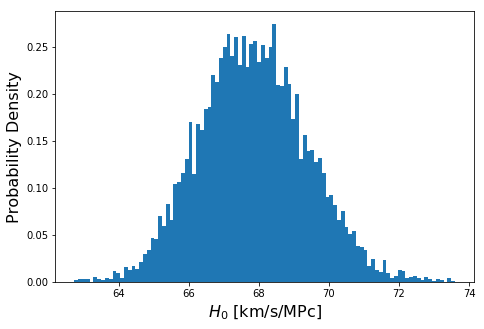

In [28]:
# We begin with the 1D plot of H0

# It's worth noting that since the first two columns of the chains are iteration and likelihood we add +2
# to the column number shown above when calling the columns in our scatter plot (i.e. we want H0 which is the 
# 7th parameter above so we plot chain[:, 9]) to get H0

# we use a histogram to look at the data here
plt.figure(figsize = (7.5,5))
plt.hist(chain[:,9], bins = 100, density = True)
plt.xlabel("$H_0$ [km/s/MPc]", fontsize = 16)
plt.ylabel("Probability Density", fontsize = 16)

It's easy to generalize to multi-dimensional projections of the likelihood, e.g. by examining the joint distribution of $H_0$ and $\Omega_m$ now:

Text(0.5,0,'$H_0$ [km/s/MPc]')

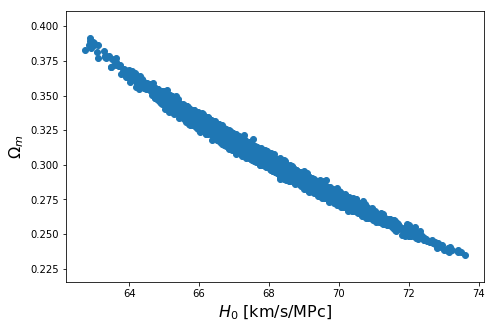

In [29]:
# Now let's try a 2D example adding in Omega Matter
plt.figure(figsize = (7.5, 5))
plt.scatter(chain[:,9], chain[:,11])
plt.ylabel("$\Omega_m$", fontsize = 16)
plt.xlabel("$H_0$ [km/s/MPc]", fontsize = 16)

Let's now make the same plots using getdist.  We need to start by reading in the files again using the getdist approach.  From there we will walk through how to make the 2 plots above.

/anaconda3/lib/python3.7/site-packages/getdist/plots.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.7/site-packages/torna

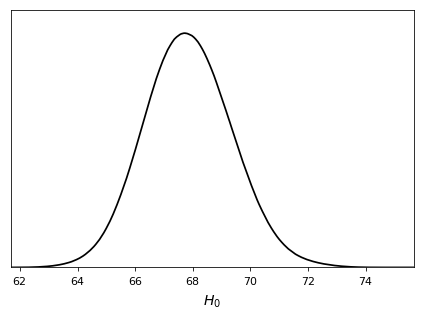

In [30]:
from getdist import loadMCSamples, plots

# Read in the samples
samples = loadMCSamples(path_to_act_notebook_data + 'ACTPol_lcdm', path_to_act_notebook_data + "ACTPol_lcdm_1.txt")

# Let's again start with the 1D version
g = plots.get_single_plotter()
g.plot_1d(samples, 'H0', marker_color='k')
plt.show()

As you can see the above plot is similar to our histogram but is much prettier!  We can also use getdist for 2D plots by using the `plot_2d` function from getdist.

((61.68027221163013, 75.67826446864929),
 (0.22068028430097586, 0.4208404853228044))

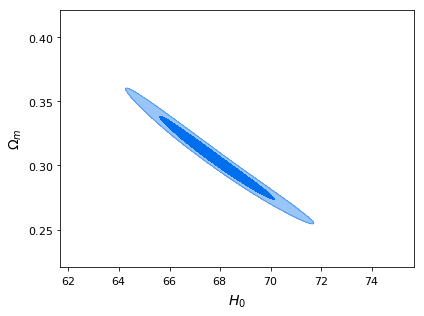

In [31]:
# We can now create a 2D contour plot using the samples we loaded above
g = plots.get_single_plotter()
g.plot_2d(samples, ['H0', 'omegam'], filled=True, )

<font color='red'>EXCERCISE: </font>  Look at correlation between other parameters.

<font color='red'>EXCERCISE: </font>  Compare these 1D and 2D with the equivalent for the chain you ran before.

In [32]:
# your code here

Your discussion here

## Part Six: (Exercise) Improving the MCMC alogoritm 
We now want to check the acceptance/rejection ratio of the chains. In general we want it to be between 0.2-0.4. To change this, you change the size of the steps in each parameter direction.

<font color='red'>EXCERCISE: </font>  Modify your code above to compute the acceptance/rejection ratio while the steps are being taken.

In [33]:
## Your code here

Your discussion here.

In general, it helps to be at a) a good part in parameter space when you start and b) to not step using a diagonal step matrix, but to step using the correlation between parameters.

<font color='red'>EXCERCISE: </font>  Modify your stepping function to take a covariance matrix (determined from a shorter run of the chain) and to step using this covariance matrix.

In [34]:
## Your code here

Your discussion here.